In [1]:
import time
import shap
import torch
import pickle
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
from computer_ontology.config import*
from sklearn.feature_selection import RFECV
from computer_ontology.custom_funcs import *
from scipy.spatial.distance import squareform
from sklearn.preprocessing import MinMaxScaler
import statsmodels.stats.weightstats as stests
from sklearn.ensemble import RandomForestClassifier
from computer_ontology.featurizer import get_mordred
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.feature_selection import VarianceThreshold, f_classif, SelectKBest
from torchmetrics.classification import MultilabelF1Score, MultilabelAUROC, MultilabelPrecision, MultilabelRecall
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [19]:
# Load the model
with open(exp_rand_xg_path_2025 , "rb") as f:
    data = pickle.load(f)
    print("Model loaded successfully")

with open(exp_rand_xg_path_2025 , "rb") as f:
    data2 = pickle.load(f)
    print("Model loaded successfully")

# Load the model
with open(exp_class_dist_path , "rb") as f:
    exp_dist = pickle.load(f)
    print("Model loaded successfully")

with open(comp_class_dist_path , "rb") as f:
    comp_dist = pickle.load(f)
    print("Model loaded successfully")

Model loaded successfully
Model loaded successfully
Model loaded successfully
Model loaded successfully


In [16]:
data = {key: data[key] + data2[key] for key in data}
data

{'f1_macro': [0.45629027485847473,
  0.452171266078949,
  0.4514636993408203,
  0.46123021841049194,
  0.4701457619667053,
  0.4476943910121918,
  0.4367679953575134,
  0.4367925524711609,
  0.46334919333457947,
  0.49502840638160706,
  0.4464477002620697,
  0.46334022283554077,
  0.468909353017807,
  0.443032830953598,
  0.47983047366142273,
  0.45930367708206177,
  0.46073117852211,
  0.4536314010620117,
  0.4454564154148102,
  0.4612393379211426,
  0.47488516569137573,
  0.4624157249927521,
  0.47366780042648315,
  0.46765464544296265,
  0.4674837589263916,
  0.4713623523712158,
  0.4813607335090637,
  0.46519264578819275,
  0.472051203250885,
  0.4514877498149872,
  0.4535694122314453,
  0.45472854375839233,
  0.4533529579639435,
  0.4600117802619934,
  0.4594627916812897,
  0.4616594612598419,
  0.41746118664741516,
  0.44894182682037354,
  0.47700753808021545,
  0.44796088337898254,
  0.45124301314353943,
  0.42965781688690186,
  0.46488380432128906,
  0.461081326007843,
  0.4246

In [ ]:
# Convert dictionary values into a NumPy array of shape (4, 100)
values = list(data.values())  # Get list of values
np_array = np.array(values)        # Convert to a NumPy array

# Check the shape
print(np_array.shape)  

(4, 1000)


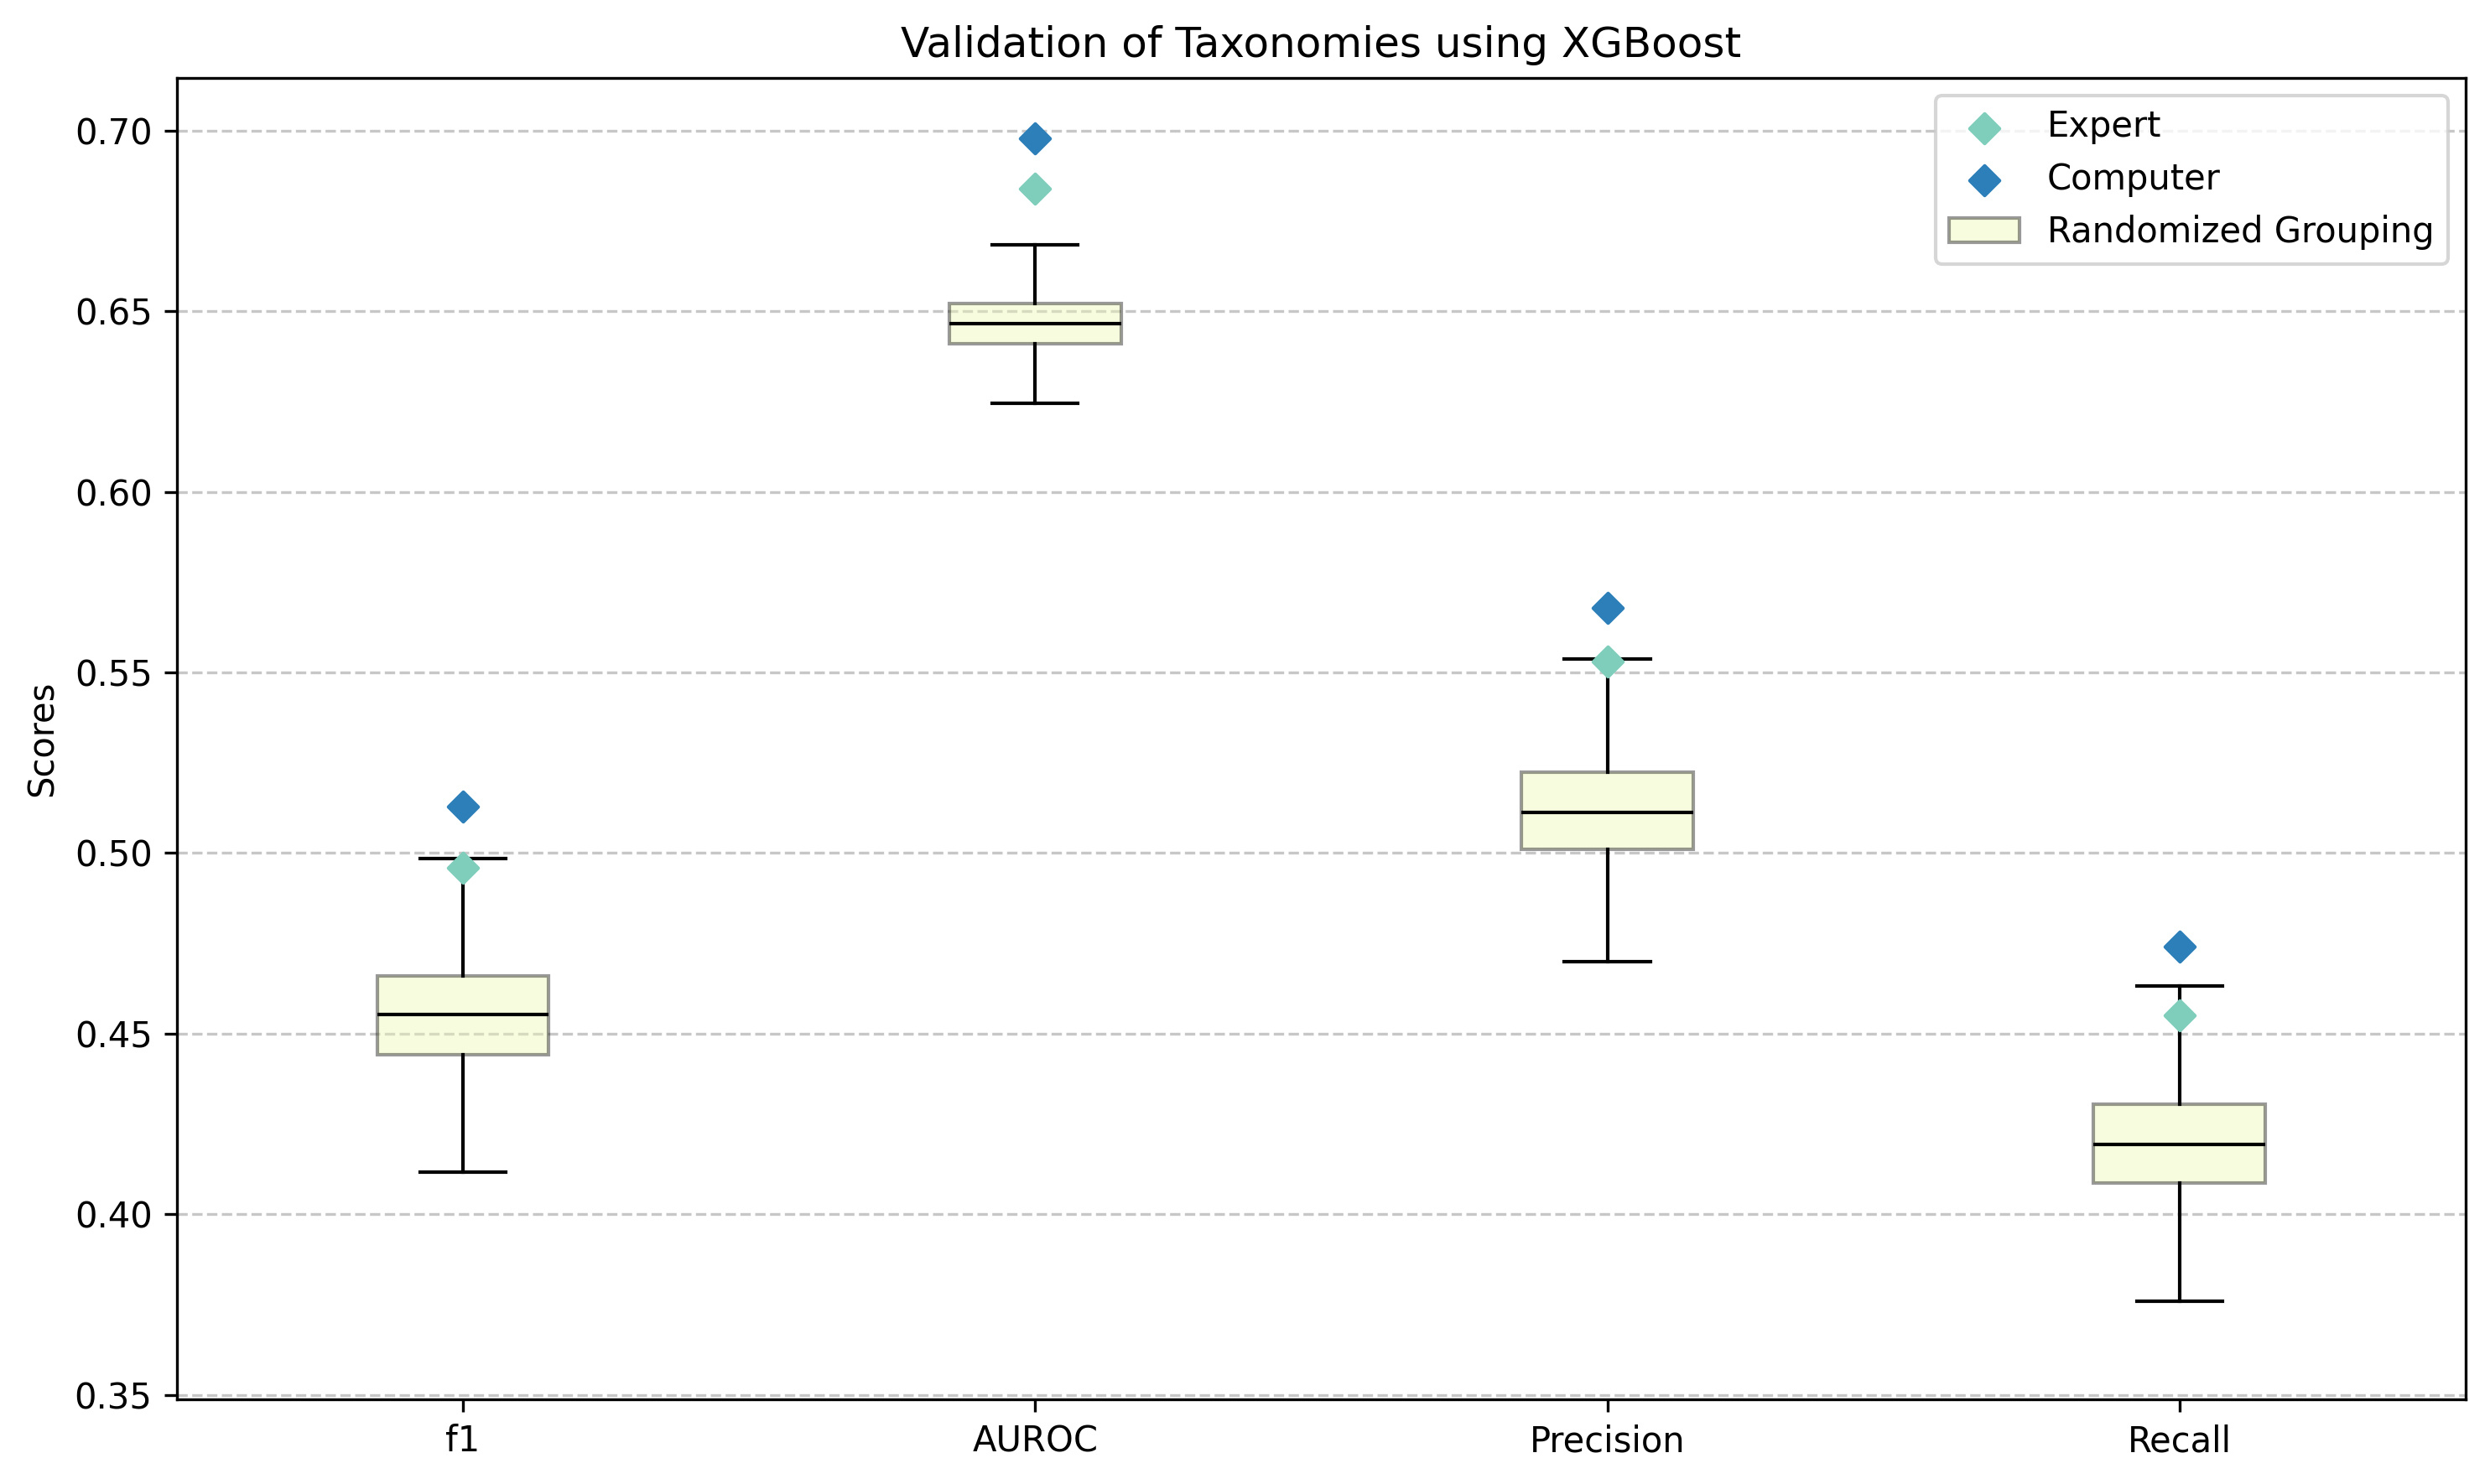

In [17]:
import matplotlib.pyplot as plt
import numpy as np

values = list(data.values())  # Get list of values
# Example data
metrics = ["f1", "AUROC", "Precision", "Recall"]
x_positions = [0,1,2,3]  # Numeric positions for the metrics
conditions = ["Expert", "Computer", "Randomized Grouping"]

#expert = [0.5048918724060059, 0.6835393905639648, 0.570635199546814, 0.46279776096343994]
#computer = [0.584128201007843, 0.7107684016227722, 0.6154874563217163, 0.559080183506012]

expert = [0.496, 0.684, 0.553, 0.455]
computer = [0.513, 0.698, 0.568, 0.474]


random  = [np.array(values) for values in data.values()]

# Plot setup
plt.figure(figsize=(10, 6), dpi=300)

# Scatter plot for Conditions 1 and 2
plt.scatter(x_positions, expert, color="#7fcdbb", label="Condition 1", marker="D", zorder=3)
plt.scatter(x_positions, computer, color="#2c7fb8", label="Condition 2", marker="D", zorder=3)

# Box plots for Condition 3 distributions
plt.boxplot(
    random, 
    positions=x_positions, 
    widths=0.3, 
    patch_artist=True,
    boxprops=dict(facecolor="#edf8b1", alpha=0.4),
    medianprops=dict(color="black"),
    flierprops=dict(marker="", alpha=0)  # Remove outlier markers
)

# Customize plot
plt.xticks(x_positions, metrics)  # Set x-ticks to metric names
plt.ylabel("Scores")
plt.title("Validation of Taxonomies using XGBoost")
plt.legend(["Expert", "Computer", "Randomized Grouping"])
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


In [32]:
# Combine the dictionaries
dist = {key: comp_dist[key] + exp_dist[key] for key in comp_dist}

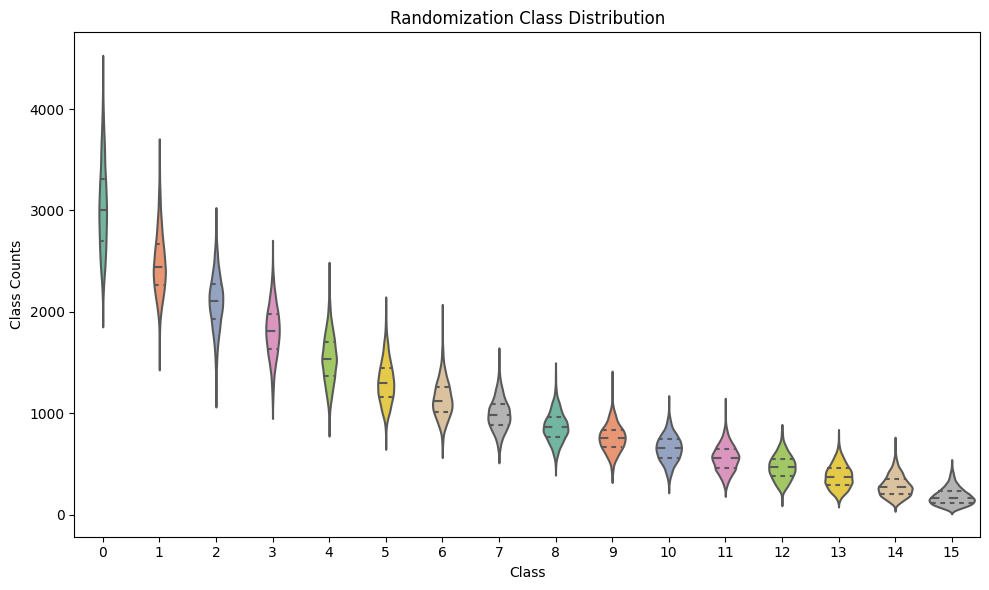

In [34]:
# Convert the dictionary to a DataFrame
data = []
for key, values in dist.items():
    for value in values:
        data.append({'Key': key, 'Value': value})

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df,
    x='Key',  # Keys on the x-axis
    y='Value',  # Values on the y-axis
    palette='Set2',  # Color palette
    inner='quartile',  # Show quartiles inside the violin
    linewidth=1.5,  # Thickness of violin edges
)

plt.title('Randomization Class Distribution')
plt.xlabel('Class')
plt.ylabel('Class Counts')
plt.tight_layout()
plt.show()

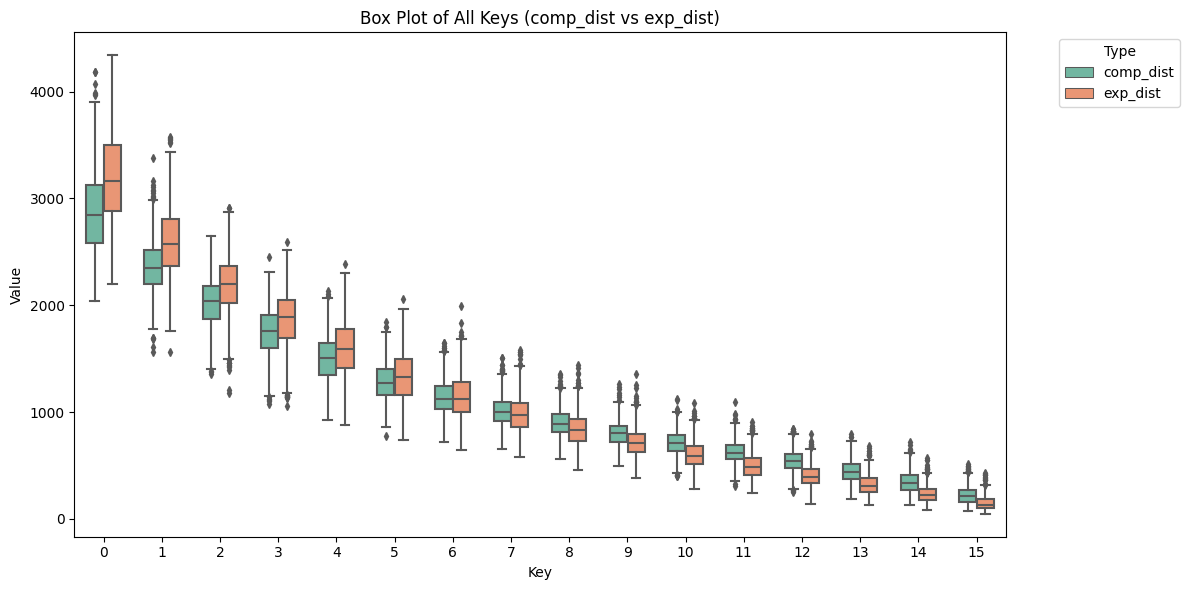

In [26]:
# Combine the data into a DataFrame
data = []
for key in comp_dist:
    for value in comp_dist[key]:
        data.append({'Key': key, 'Value': value, 'Type': 'comp_dist'})
    for value in exp_dist[key]:
        data.append({'Key': key, 'Value': value, 'Type': 'exp_dist'})

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x='Key',  # Keys on the x-axis
    y='Value',  # Values on the y-axis
    hue='Type',  # Differentiate comp_dist and exp_dist
    palette='Set2',  # Color palette
    width=0.6,  # Width of the boxes
    linewidth=1.5,  # Thickness of box edges
    fliersize=4,  # Size of outlier markers
)

plt.title('Box Plot of All Keys (comp_dist vs exp_dist)')
plt.xlabel('Key')
plt.ylabel('Value')
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.tight_layout()
plt.show()